In [4]:
import sklearn
import matplotlib.pyplot as plt
plt.style.use('lqcd')
import numpy as np

from sklearn.ensemble import RandomForestClassifier

In [3]:
X_train = np.load("data/X_train.npy")
X_test = np.load("data/X_test.npy")
y_train = np.load("data/y_train.npy")

In [13]:
ensemble = [
    ("RandomForestClassifier, max_features='sqrt'",
    RandomForestClassifier(
        warm_start=True,
        bootstrap=True,
        oob_score=True,
        max_features='sqrt',
        random_state=42,
    )),
    ("RandomForestClassifier, max_features='log2'",
    RandomForestClassifier(
        warm_start=True,
        oob_score=True,
        bootstrap=True,
        max_features='log2',
        random_state=42,
    )),
    ("RandomForestClassifier, max_features=None",
    RandomForestClassifier(
        warm_start=True,
        oob_score=True,
        bootstrap=True,
        max_features=None,
        random_state=42,
    )),
]


error_rate = {label: [] for label, _ in ensemble}

estimator_range = np.arange(25, 200, 5)

for label, clf in ensemble:
    for n_estimators in estimator_range:
        clf.set_params(n_estimators=n_estimators)
        clf.fit(X_train, y_train)

        oob_error = 1 - clf.oob_score_
        error_rate[label].append(oob_error)

Text(0, 0.5, 'OOB Error Rate')

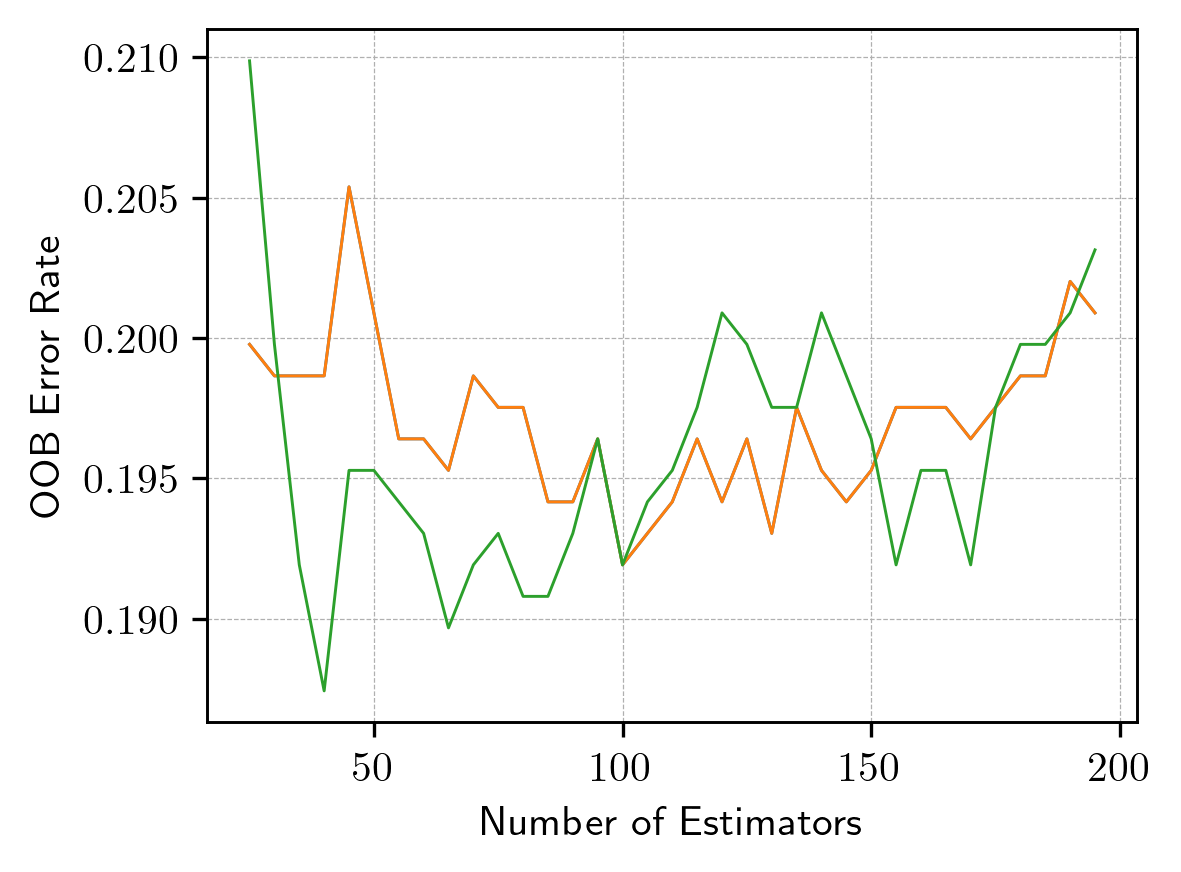

In [14]:
fig, ax = plt.subplots(figsize=(4, 3))

for label, clf in ensemble:
    ax.plot(estimator_range, error_rate[label], label=label)

ax.set_xlabel("Number of Estimators")
ax.set_ylabel("OOB Error Rate")

In [23]:
cf = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    warm_start=True,
    oob_score=True,
)


cf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


Text(0, 0.5, 'Importance Score')

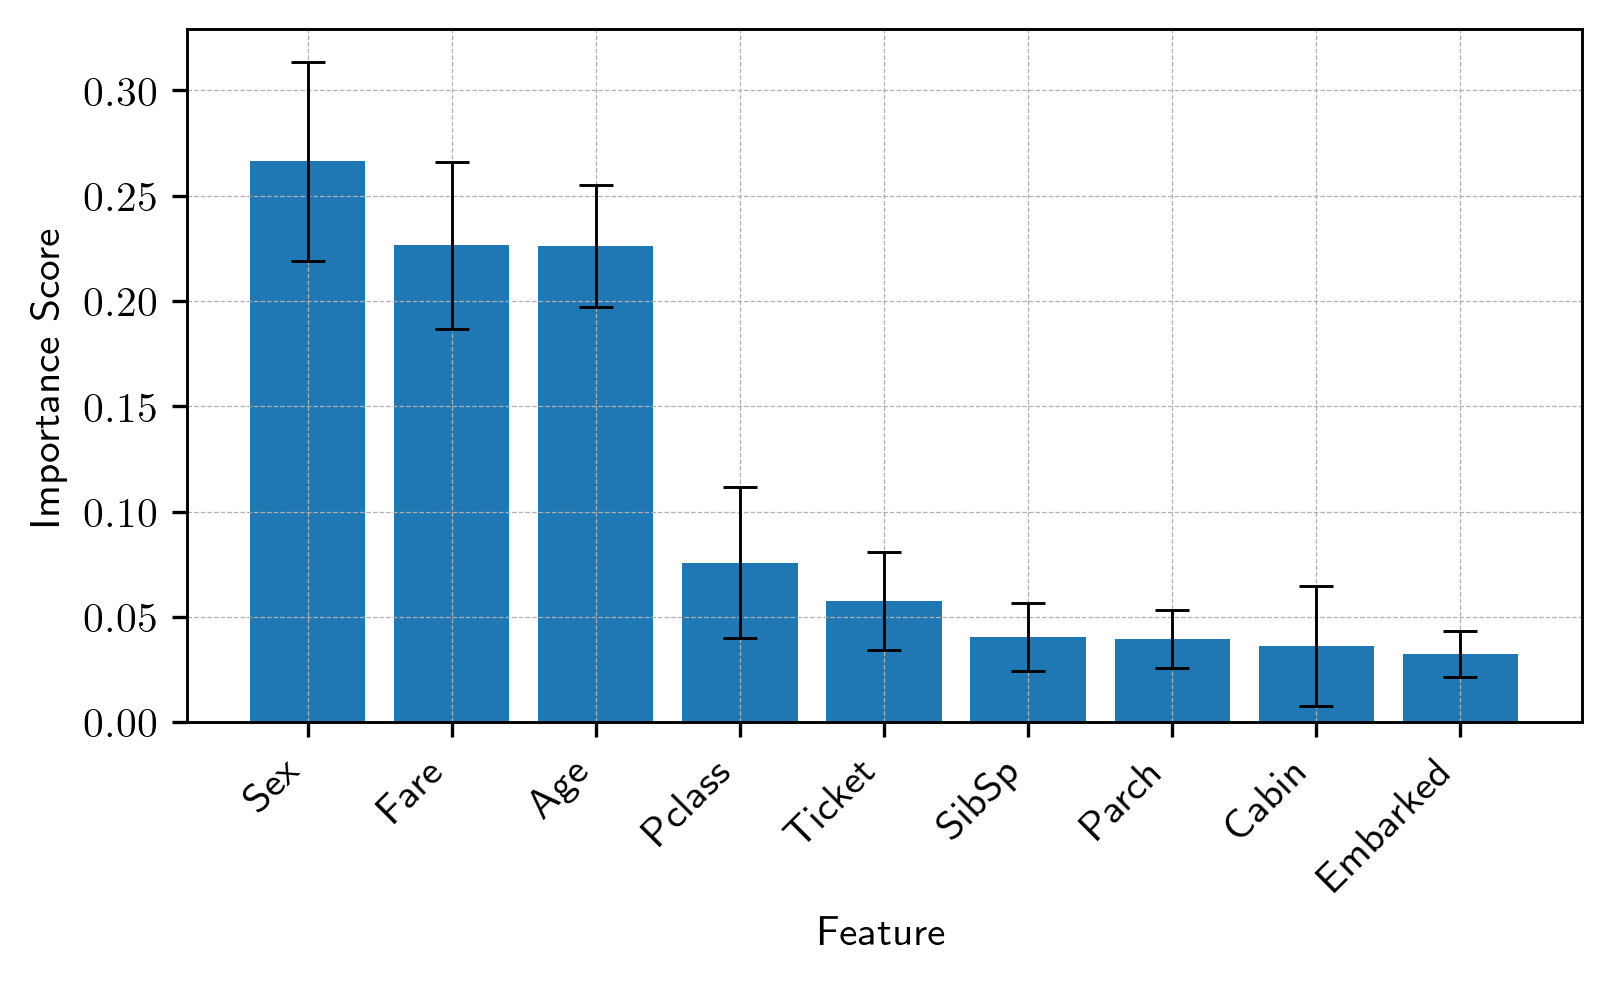

In [33]:
importances = cf.feature_importances_
std = np.std([tree.feature_importances_ for tree in cf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

feature_names = [
    'Pclass',
    'Sex',
    'Age',
    'SibSp',
    'Parch',
    'Ticket',
    'Fare',
    'Cabin',
    'Embarked',
]

fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(range(X_train.shape[1]), importances[indices],
       color="tab:blue", yerr=std[indices], align="center")
ax.set_xticks(range(X_train.shape[1]))
ax.set_xticklabels(np.array(feature_names)[indices], rotation=45, ha='right')
ax.set_xlabel("Feature")
ax.set_ylabel("Importance Score")

# Hyperparameter Tuning

In [52]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold


rf = RandomForestClassifier(
    n_jobs=-1,
    oob_score=True,
    random_state=42,
    bootstrap=True,
    warm_start=True,
)

param_dist = {
    "n_estimators": np.arange(50, 200, 10),
    "max_depth": [2,3,4,5, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.3, 0.5, 0.7, 1.0, None],
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

rand = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=100,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42,
)

rand.fit(X_train, y_train)

,estimator,RandomForestC...rm_start=True)
,param_distributions,"{'max_depth': [2, 3, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,100
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [53]:
rand.best_params_

{'n_estimators': np.int64(90),
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 0.3,
 'max_depth': None}

In [56]:
grid_params = {
    "n_estimators": [rand.best_params_["n_estimators"] - 10,
                     rand.best_params_["n_estimators"],
                     rand.best_params_["n_estimators"] + 10],
    "min_samples_split": [rand.best_params_["min_samples_split"],
                          rand.best_params_["min_samples_split"] + 1],
    "min_samples_leaf": [rand.best_params_["min_samples_leaf"] - 1,
                         rand.best_params_["min_samples_leaf"],
                         rand.best_params_["min_samples_leaf"] + 1],
    "max_features": [rand.best_params_["max_features"]],
    "max_depth": [rand.best_params_["max_depth"]],
}

grid = GridSearchCV(
    rf,
    param_grid=grid_params,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


,estimator,RandomForestC...rm_start=True)
,param_grid,"{'max_depth': [None], 'max_features': [0.3], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 3], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,np.int64(80)


In [57]:
best_rf = grid.best_estimator_

In [ ]:
y_pred = best_rf.predict(X_test)

In [70]:
import pandas as pd 

td = pd.read_csv("./data/test.csv")

rd = pd.DataFrame({"PassengerID": td['PassengerId'], "Survived": y_pred})
rd.to_csv("./data/result_random_forest.csv", index=False)

##### Final Score: 0.76076